# WLTP Cycle 3B calibration notebook

Measured values

In [2438]:
# Measured FE (L/100km)
meas_fe_combined = 3.8
meas_fe_low = 2.9
meas_fe_med = 3
meas_fe_high = 3.5
meas_fe_extrahigh = 5

# Measured CO2 emissions (g/km)
meas_CO2_combined = 87
meas_CO2_low = 66
meas_CO2_med = 68
meas_CO2_high = 79
meas_CO2_extrahigh = 113

Constants

In [2439]:
L_PER_GAL = 3.78541
WILLANS_FACTOR = 724  # gCO2/MJ
E10_HEAT_VALUE = 8.64  # kWh/L

Function definitions

In [2440]:
def mpgge_to_litersPer100km(mpgge):
    return (1 / mpgge) * (1 / fastsim.params.metersPerMile) * 1000 * 100 * L_PER_GAL

Code

In [2441]:
import fastsim
from matplotlib import pyplot as plt

In [2442]:
# Load vehicle
veh = fastsim.vehicle.Vehicle(veh_file="../resources/vehdb/2022_TOYOTA_Yaris_Hybrid_Mid.csv")

fcEffMap is overriding fcEffType in ../resources/vehdb/2022_TOYOTA_Yaris_Hybrid_Mid_camelCase.csv


In [2443]:
# Load WLTC cycle phases
cyc_low = fastsim.cycle.Cycle(cyc_file_path="../resources/cycles/wltc_class3_low3.csv")
cyc_med = fastsim.cycle.Cycle(cyc_file_path="../resources/cycles/wltc_class3_med3b.csv")
cyc_high = fastsim.cycle.Cycle(cyc_file_path="../resources/cycles/wltc_class3_high3b.csv")
cyc_extrahigh = fastsim.cycle.Cycle(cyc_file_path="../resources/cycles/wltc_class3_extra_high3.csv")

In [2444]:
# Generate combined cycle
cyc_combined_dict = fastsim.cycle.concat(
    [
        cyc_low.get_cyc_dict(),
        cyc_med.get_cyc_dict(),
        cyc_high.get_cyc_dict(),
        cyc_extrahigh.get_cyc_dict(),
    ]
)
cyc = fastsim.cycle.Cycle(cyc_dict=cyc_combined_dict)

In [2445]:
# Simulate combined cycle
sim = fastsim.simdrive.SimDriveClassic(cyc, veh)
sim.sim_drive()

In [2446]:
# Calculate FE
dist_miles_combined = sim.distMiles.sum()
energy_combined = sim.fsKwhOutAch.sum()
fe_mpgge_combined = dist_miles_combined / (energy_combined/sim.props.kWhPerGGE)
fe_litersPer100km_combined = mpgge_to_litersPer100km(fe_mpgge_combined)
print(f"{fe_litersPer100km_combined:.2f} L/100km")
print(f"{abs(fe_litersPer100km_combined - meas_fe_combined)/meas_fe_combined * 100:.2f}%")

3.80 L/100km
0.08%


In [2447]:
i0 = len(cyc_low.cycSecs)
i1 = i0 + len(cyc_med.cycSecs)-1
i2 = i1 + len(cyc_high.cycSecs)-1

low = slice(None, i0)
medium = slice(i0-1, i1)
high = slice(i1-1, i2)
extrahigh = slice(i2-1, None)

WLTC 3 Low

In [2448]:
# Calculate FE
dist_miles_low = sim.distMiles[low].sum()
energy_low = sim.fsKwhOutAch[low].sum()
fe_mpgge_low = dist_miles_low / (energy_low/sim.props.kWhPerGGE)
fe_litersPer100km_low = mpgge_to_litersPer100km(fe_mpgge_low)
print(f"{fe_litersPer100km_low:.2f} L/100km")
print(f"{abs(fe_litersPer100km_low - meas_fe_low)/meas_fe_low * 100:.2f}%")

2.50 L/100km
13.82%


In [2449]:
# Calculate ΔSOC (negative is decrease)
dSOC_low = sim.soc[i0-1] - sim.soc[0]
print(f"{dSOC_low:+.5f}")

-0.08744


In [2450]:
# Calculate ESS energy expended (positive is decrease)
dE_low = -dSOC_low * veh.maxEssKwh * 1000
print(f"{dE_low:.2f} Wh")

66.81 Wh


In [2451]:
# Calculate distance in km
dist_km_low = dist_miles_low * fastsim.params.metersPerMile / 1000
print(f"{dist_km_low:.2f} km")

3.09 km


In [2452]:
# Calculate CO2 emissions (gCO2/km)
dM_low = 0.0036 * dE_low * 1/veh.altEff * WILLANS_FACTOR * 1/dist_km_low
print(f"{dM_low:.2f} gCO2/km")

62.52 gCO2/km


In [2453]:
# Calculate equivalent fuel consumption (L)
fe_adjustment_low = dE_low/1000 * 1/veh.altEff * 1/E10_HEAT_VALUE * 100/dist_km_low
print(f"{fe_adjustment_low:+.5f} L/100km")

# Calculate adjusted FE
fe_litersPer100km_low_adj = fe_litersPer100km_low + fe_adjustment_low
print(f"{fe_litersPer100km_low_adj:.2f} L/100km")
print(f"{abs(fe_litersPer100km_low_adj - meas_fe_low)/meas_fe_low * 100:.2f}%")

+0.27764 L/100km
2.78 L/100km
4.25%


WLTC 3B Medium

In [2454]:
# Calculate FE
dist_miles_med = sim.distMiles[medium].sum()
energy_med = sim.fsKwhOutAch[medium].sum()
fe_mpgge_med = dist_miles_med / (energy_med/sim.props.kWhPerGGE)
fe_litersPer100km_med = mpgge_to_litersPer100km(fe_mpgge_med)
print(f"{fe_litersPer100km_med:.2f} L/100km")
print(f"{abs(fe_litersPer100km_med - meas_fe_med)/meas_fe_med * 100:.2f}%")

3.21 L/100km
6.88%


In [2455]:
# Calculate ΔSOC (negative is decrease)
dSOC_med = sim.soc[i1-1] - sim.soc[i0-1]
print(f"{dSOC_med:+.5f}")

+0.03663


In [2456]:
# Calculate ESS energy expended (positive is decrease)
dE_med = -dSOC_med * veh.maxEssKwh * 1000
print(f"{dE_med:.2f} Wh")

-27.98 Wh


In [2457]:
# Calculate distance in km
dist_km_med = dist_miles_med * fastsim.params.metersPerMile / 1000
print(f"{dist_km_med:.2f} km")

4.76 km


In [2458]:
# Calculate CO2 emissions (gCO2/km)
dM_med = 0.0036 * dE_med * 1/veh.altEff * WILLANS_FACTOR * 1/dist_km_med
print(f"{dM_med:.2f} gCO2/km")

-17.04 gCO2/km


In [2459]:
# Calculate equivalent fuel consumption (L)
fe_adjustment_med = dE_med/1000 * 1/veh.altEff * 1/E10_HEAT_VALUE * 100/dist_km_med
print(f"{fe_adjustment_med:+.5f} L/100km")

# Calculate adjusted FE
fe_litersPer100km_med_adj = fe_litersPer100km_med + fe_adjustment_med
print(f"{fe_litersPer100km_med_adj:.2f} L/100km")
print(f"{abs(fe_litersPer100km_med_adj - meas_fe_med)/meas_fe_med * 100:.2f}%")

-0.07567 L/100km
3.13 L/100km
4.36%


WLTC 3B High

In [2460]:
# Calculate FE
dist_miles_high = sim.distMiles[high].sum()
energy_high = sim.fsKwhOutAch[high].sum()
fe_mpgge_high = dist_miles_high / (energy_high/sim.props.kWhPerGGE)
fe_litersPer100km_high = mpgge_to_litersPer100km(fe_mpgge_high)
print(f"{fe_litersPer100km_high:.2f} L/100km")
print(f"{abs(fe_litersPer100km_high - meas_fe_high)/meas_fe_high * 100:.2f}%")

3.30 L/100km
5.84%


In [2461]:
# Calculate ΔSOC (negative is decrease)
dSOC_high = sim.soc[i2-1] - sim.soc[i1-1]
print(f"{dSOC_high:+.5f}")

-0.02737


In [2462]:
# Calculate ESS energy expended (positive is decrease)
dE_high = -dSOC_high * veh.maxEssKwh * 1000
print(f"{dE_high:.2f} Wh")

20.91 Wh


In [2463]:
# Calculate distance in km
dist_km_high = dist_miles_high * fastsim.params.metersPerMile / 1000
print(f"{dist_km_high:.2f} km")

7.16 km


In [2464]:
# Calculate CO2 emissions (gCO2/km)
dM_high = 0.0036 * dE_high * 1/veh.altEff * WILLANS_FACTOR * 1/dist_km_high
print(f"{dM_high:.2f} gCO2/km")

8.46 gCO2/km


In [2465]:
# Calculate equivalent fuel consumption (L)
fe_adjustment_high = dE_high/1000 * 1/veh.altEff * 1/E10_HEAT_VALUE * 100/dist_km_high
print(f"{fe_adjustment_high:+.5f} L/100km")

# Calculate adjusted FE
fe_litersPer100km_high_adj = fe_litersPer100km_high + fe_adjustment_high
print(f"{fe_litersPer100km_high_adj:.2f} L/100km")
print(f"{abs(fe_litersPer100km_high_adj - meas_fe_high)/meas_fe_high * 100:.2f}%")

+0.03755 L/100km
3.33 L/100km
4.77%


WLTC 3 Extra-High

In [2466]:
# Calculate FE
dist_miles_extrahigh = sim.distMiles[extrahigh].sum()
energy_extrahigh = sim.fsKwhOutAch[extrahigh].sum()
fe_mpgge_extrahigh = dist_miles_extrahigh / (energy_extrahigh/sim.props.kWhPerGGE)
fe_litersPer100km_extrahigh = mpgge_to_litersPer100km(fe_mpgge_extrahigh)
print(f"{fe_litersPer100km_extrahigh:.2f} L/100km")
print(f"{abs(fe_litersPer100km_extrahigh - meas_fe_extrahigh)/meas_fe_extrahigh * 100:.2f}%")

5.08 L/100km
1.51%


In [2467]:
# Calculate ΔSOC (negative is decrease)
dSOC_extrahigh = sim.soc[-1] - sim.soc[i2-1]
print(f"{dSOC_extrahigh:+.5f}")

+0.07819


In [2468]:
# Calculate ESS energy expended (positive is decrease)
dE_extrahigh = -dSOC_extrahigh * veh.maxEssKwh * 1000
print(f"{dE_extrahigh:.2f} Wh")

-59.74 Wh


In [2469]:
# Calculate distance in km
dist_km_extrahigh = dist_miles_extrahigh * fastsim.params.metersPerMile / 1000
print(f"{dist_km_extrahigh:.2f} km")

8.25 km


In [2470]:
# Calculate CO2 emissions (gCO2/km)
dM_extrahigh = 0.0036 * dE_extrahigh * 1/veh.altEff * WILLANS_FACTOR * 1/dist_km_extrahigh
print(f"{dM_extrahigh:.2f} gCO2/km")

-20.96 gCO2/km


In [2471]:
# Calculate equivalent fuel consumption (L/100km)
fe_adjustment_extrahigh = dE_extrahigh/1000 * 1/veh.altEff * 1/E10_HEAT_VALUE * 100/dist_km_extrahigh
print(f"{fe_adjustment_extrahigh:+.5f} L/100km")

# Calculate adjusted FE
fe_litersPer100km_extrahigh_adj = fe_litersPer100km_extrahigh + fe_adjustment_extrahigh
print(f"{fe_litersPer100km_extrahigh_adj:.2f} L/100km")
print(f"{abs(fe_litersPer100km_extrahigh_adj - meas_fe_extrahigh)/meas_fe_extrahigh * 100:.2f}%")

-0.09307 L/100km
4.98 L/100km
0.35%


In [2472]:
print("LOW")
print(f"  Target: {meas_fe_low} L/100km")
print(f"  Before: {fe_litersPer100km_low:.2f} L/100km ({(fe_litersPer100km_low - meas_fe_low)/meas_fe_low * 100:+.2f}%)")
print(f"  After:  {fe_litersPer100km_low_adj:.2f} L/100km ({(fe_litersPer100km_low_adj - meas_fe_low)/meas_fe_low * 100:+.2f}%)")

print("MEDIUM")
print(f"  Target: {meas_fe_med} L/100km")
print(f"  Before: {fe_litersPer100km_med:.2f} L/100km ({(fe_litersPer100km_med - meas_fe_med)/meas_fe_med * 100:+.2f}%)")
print(f"  After:  {fe_litersPer100km_med_adj:.2f} L/100km ({(fe_litersPer100km_med_adj - meas_fe_med)/meas_fe_med * 100:+.2f}%)")

print("HIGH")
print(f"  Target: {meas_fe_high} L/100km")
print(f"  Before: {fe_litersPer100km_high:.2f} L/100km ({(fe_litersPer100km_high - meas_fe_high)/meas_fe_high * 100:+.2f}%)")
print(f"  After:  {fe_litersPer100km_high_adj:.2f} L/100km ({(fe_litersPer100km_high_adj - meas_fe_high)/meas_fe_high * 100:+.2f}%)")

print("EXTRA-HIGH")
print(f"  Target: {meas_fe_extrahigh} L/100km")
print(f"  Before: {fe_litersPer100km_extrahigh:.2f} L/100km ({(fe_litersPer100km_extrahigh - meas_fe_extrahigh)/meas_fe_extrahigh * 100:+.2f}%)")
print(f"  After:  {fe_litersPer100km_extrahigh_adj:.2f} L/100km ({(fe_litersPer100km_extrahigh_adj - meas_fe_extrahigh)/meas_fe_extrahigh * 100:+.2f}%)")

print("COMBINED")
print(f"  Target: {meas_fe_combined} L/100km")
print(f"  Before: {fe_litersPer100km_combined:.2f} L/100km ({(fe_litersPer100km_combined - meas_fe_combined)/meas_fe_combined * 100:+.2f}%)")

LOW
  Target: 2.9 L/100km
  Before: 2.50 L/100km (-13.82%)
  After:  2.78 L/100km (-4.25%)
MEDIUM
  Target: 3 L/100km
  Before: 3.21 L/100km (+6.88%)
  After:  3.13 L/100km (+4.36%)
HIGH
  Target: 3.5 L/100km
  Before: 3.30 L/100km (-5.84%)
  After:  3.33 L/100km (-4.77%)
EXTRA-HIGH
  Target: 5 L/100km
  Before: 5.08 L/100km (+1.51%)
  After:  4.98 L/100km (-0.35%)
COMBINED
  Target: 3.8 L/100km
  Before: 3.80 L/100km (+0.08%)


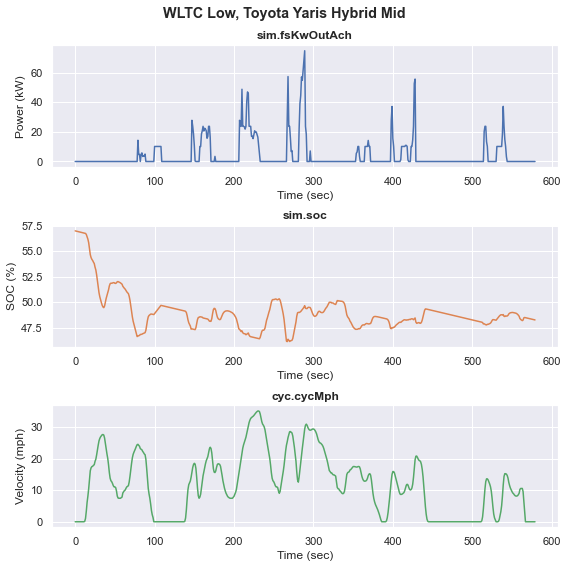

In [2479]:
fig1 = plt.figure(figsize=(8,8))

x = cyc.cycSecs[low]

fig1.suptitle("WLTC Low, Toyota Yaris Hybrid Mid", fontweight="bold", size="x-large")

y1 = sim.fsKwOutAch[low]
ax1 = fig1.add_subplot(311)
ax1.plot(x, y1, color="C0")
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Power (kW)")
ax1.set_title("sim.fsKwOutAch", fontweight="bold")

y2 = sim.soc[low] * 100
ax2 = fig1.add_subplot(312, sharex=ax1)
ax2.plot(x, y2, color="C1")
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("SOC (%)")
ax2.set_title("sim.soc", fontweight="bold")

y3 = cyc.cycMph[low]
ax3 = fig1.add_subplot(313, sharex=ax1)
ax3.plot(x, y3, color="C2")
ax3.set_xlabel("Time (sec)")
ax3.set_ylabel("Velocity (mph)")
ax3.set_title("cyc.cycMph", fontweight="bold")

plt.tight_layout()
# plt.savefig("C:/Users/kcarow/Downloads/low.jpg")

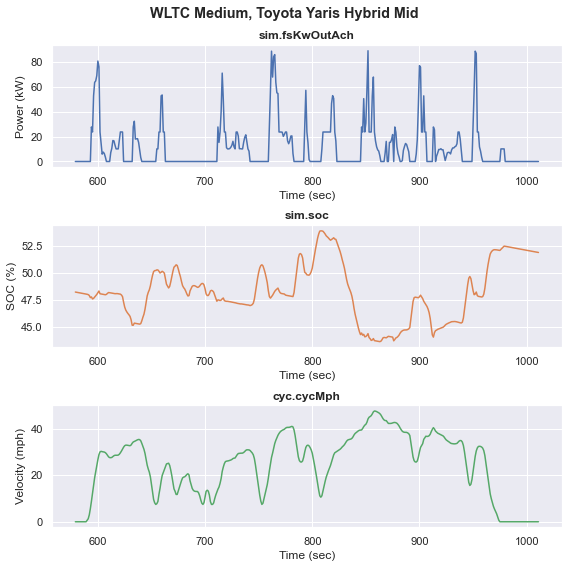

In [2480]:
fig2 = plt.figure(figsize=(8,8))

x = cyc.cycSecs[medium]

fig2.suptitle("WLTC Medium, Toyota Yaris Hybrid Mid", fontweight="bold", size="x-large")

y1 = sim.fsKwOutAch[medium]
ax1 = fig2.add_subplot(311)
ax1.plot(x, y1, color="C0")
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Power (kW)")
ax1.set_title("sim.fsKwOutAch", fontweight="bold")

y2 = sim.soc[medium] * 100
ax2 = fig2.add_subplot(312, sharex=ax1)
ax2.plot(x, y2, color="C1")
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("SOC (%)")
ax2.set_title("sim.soc", fontweight="bold")

y3 = cyc.cycMph[medium]
ax3 = fig2.add_subplot(313, sharex=ax1)
ax3.plot(x, y3, color="C2")
ax3.set_xlabel("Time (sec)")
ax3.set_ylabel("Velocity (mph)")
ax3.set_title("cyc.cycMph", fontweight="bold")

plt.tight_layout()
# plt.savefig("C:/Users/kcarow/Downloads/medium.jpg")

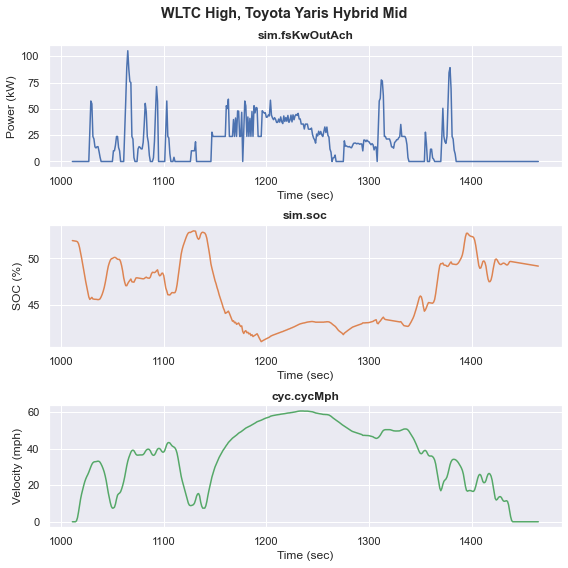

In [2481]:
fig3 = plt.figure(figsize=(8,8))

x = cyc.cycSecs[high]

fig3.suptitle("WLTC High, Toyota Yaris Hybrid Mid", fontweight="bold", size="x-large")

y1 = sim.fsKwOutAch[high]
ax1 = fig3.add_subplot(311)
ax1.plot(x, y1, color="C0")
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Power (kW)")
ax1.set_title("sim.fsKwOutAch", fontweight="bold")

y2 = sim.soc[high] * 100
ax2 = fig3.add_subplot(312, sharex=ax1)
ax2.plot(x, y2, color="C1")
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("SOC (%)")
ax2.set_title("sim.soc", fontweight="bold")

y3 = cyc.cycMph[high]
ax3 = fig3.add_subplot(313, sharex=ax1)
ax3.plot(x, y3, color="C2")
ax3.set_xlabel("Time (sec)")
ax3.set_ylabel("Velocity (mph)")
ax3.set_title("cyc.cycMph", fontweight="bold")

plt.tight_layout()
# plt.savefig("C:/Users/kcarow/Downloads/high.jpg")

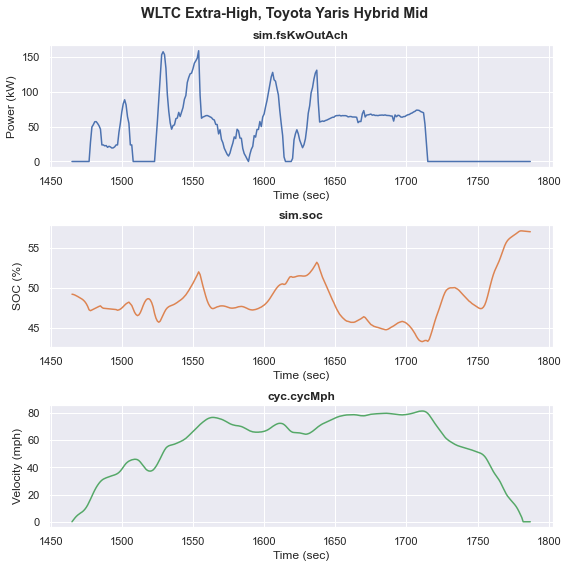

In [2482]:
fig4 = plt.figure(figsize=(8,8))

x = cyc.cycSecs[extrahigh]

fig4.suptitle("WLTC Extra-High, Toyota Yaris Hybrid Mid", fontweight="bold", size="x-large")

y1 = sim.fsKwOutAch[extrahigh]
ax1 = fig4.add_subplot(311)
ax1.plot(x, y1, color="C0")
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Power (kW)")
ax1.set_title("sim.fsKwOutAch", fontweight="bold")

y2 = sim.soc[extrahigh] * 100
ax2 = fig4.add_subplot(312, sharex=ax1)
ax2.plot(x, y2, color="C1")
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("SOC (%)")
ax2.set_title("sim.soc", fontweight="bold")

y3 = cyc.cycMph[extrahigh]
ax3 = fig4.add_subplot(313, sharex=ax1)
ax3.plot(x, y3, color="C2")
ax3.set_xlabel("Time (sec)")
ax3.set_ylabel("Velocity (mph)")
ax3.set_title("cyc.cycMph", fontweight="bold")

plt.tight_layout()
# plt.savefig("C:/Users/kcarow/Downloads/extra-high.jpg")

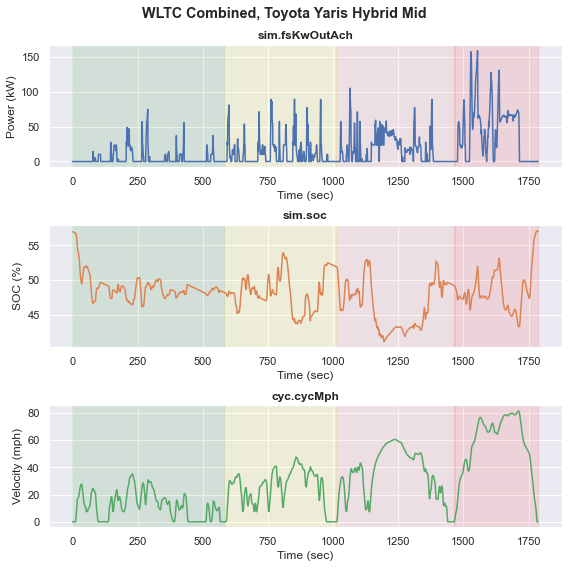

In [2483]:
fig5 = plt.figure(figsize=(8,8))

x = cyc.cycSecs

fig5.suptitle("WLTC Combined, Toyota Yaris Hybrid Mid", fontweight="bold", size="x-large")

y1 = sim.fsKwOutAch
ax1 = fig5.add_subplot(311)
ax1.plot(x, y1, color="C0")
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Power (kW)")
ax1.set_title("sim.fsKwOutAch", fontweight="bold")
ax1.axvspan(0, i0, color="green", alpha=0.1)
ax1.axvspan(i0-1, i1, color="yellow", alpha=0.1)
ax1.axvspan(i1-1, i2, color="salmon", alpha=0.1)
ax1.axvspan(i2-1, max(x), color="red", alpha=0.1)

y2 = sim.soc * 100
ax2 = fig5.add_subplot(312, sharex=ax1)
ax2.plot(x, y2, color="C1")
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("SOC (%)")
ax2.set_title("sim.soc", fontweight="bold")
ax2.axvspan(0, i0, color="green", alpha=0.1)
ax2.axvspan(i0-1, i1, color="yellow", alpha=0.1)
ax2.axvspan(i1-1, i2, color="salmon", alpha=0.1)
ax2.axvspan(i2-1, max(x), color="red", alpha=0.1)

y3 = cyc.cycMph
ax3 = fig5.add_subplot(313, sharex=ax1)
ax3.plot(x, y3, color="C2")
ax3.set_xlabel("Time (sec)")
ax3.set_ylabel("Velocity (mph)")
ax3.set_title("cyc.cycMph", fontweight="bold")
ax3.axvspan(0, i0, color="green", alpha=0.1)
ax3.axvspan(i0-1, i1, color="yellow", alpha=0.1)
ax3.axvspan(i1-1, i2, color="salmon", alpha=0.1)
ax3.axvspan(i2-1, max(x), color="red", alpha=0.1)

plt.tight_layout()
# plt.savefig("C:/Users/kcarow/Downloads/combined.jpg")